Training started...
Processing dataset: 228_elusage.tsv
{'feature_selection__k': 1, 'regression__fit_intercept': True, 'regression__max_subpopulation': 500, 'regression__tol': 0.01}
R-square score: 0.71


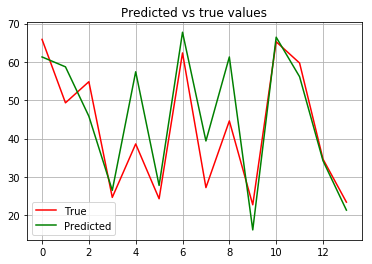

---------------------


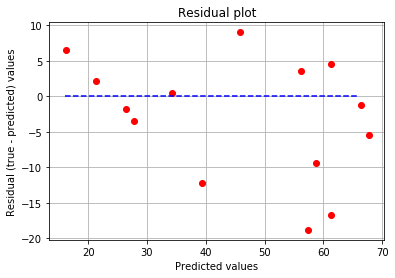

Finished dataset: 228_elusage.tsv
------------------------------------------------------------
Processing dataset: 485_analcatdata_vehicle.tsv


In [ ]:
import sys
import time
import pandas as pd
from sklearn import model_selection
from sklearn import linear_model, metrics, cluster
from matplotlib import pyplot as plt
import scipy
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import *
from sklearn.model_selection import GridSearchCV
import warnings


warnings.filterwarnings('ignore')


%matplotlib inline
start_time = time.time()
datasets = ["228_elusage.tsv", "485_analcatdata_vehicle.tsv", "523_analcatdata_neavote.tsv", \
            '663_rabe_266.tsv', '687_sleuth_ex1605.tsv']

#datasets = ["1029_LEV.tsv"]

regressor = Pipeline([
  ('preprocessing', preprocessing.RobustScaler()),
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', linear_model.TheilSenRegressor())
])

parameters = [{ \
    'feature_selection__k': [1, 2, 3, 4, 'all'], \
    'regression__max_subpopulation': [1000, 2000, 500], \
    'regression__fit_intercept': [True, False], \
    'regression__tol':  [0.000001, 0.00001, 0.001, 0.01, 0.1], \
}]

print('Training started...')
dataset_accuracies = list()
r2_scores = list()
for d_set in datasets:
    print("Processing dataset: %s" % d_set)
    data_path = "data/" + d_set
    df = pd.read_csv(data_path, sep="\t")
    label = df["target"].copy()
    data = df.drop("target", axis=1)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, test_size=0.25, random_state=42)
    
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    optimized_regressor = GridSearchCV(regressor, parameters, cv=5, error_score=0)
    
    optimized_regressor.fit(X_train, y_train)
    best_regressor = optimized_regressor.best_estimator_
    best_result = optimized_regressor.cv_results_
    
    print(optimized_regressor.best_params_)
    prediction = best_regressor.predict(X_test)
    
    #mse = np.mean([np.abs(x-y) for x, y in zip(prediction, y_test)])
    r2_square = metrics.r2_score(y_test, prediction)
    r2_scores.append(r2_square)
    residual = y_test - prediction
    print("R-square score: %0.2f" % r2_square)
    
    plt.figure()
    plt.plot(y_test, color='r')
    plt.plot(prediction, color='g')
    plt.grid(True)
    plt.legend(['True', 'Predicted'])
    plt.title('Predicted vs true values')
    plt.show()
    
    print("---------------------")
    
    plt.figure()
    plt.plot(prediction, residual, 'ro')
    max_pred = int(np.max(prediction))
    min_pred = int(np.min(prediction))
    plt.plot(np.arange(min_pred, max_pred), [0 for i in range(max_pred - min_pred)], 'b--')
    plt.grid(True)
    plt.xlabel('Predicted values')
    plt.ylabel('Residual (true - predicted) values')
    plt.title('Residual plot')
    plt.show()
    
    print("Finished dataset: %s" % d_set)
    print("------------------------------------------------------------")

print('Training finished')
print("Mean R2 square: \n", np.mean(r2_scores))
end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))